# Navigation

---

In this notebook, we will make use of Unity ML-Agents environment.

### 1. Start the Environment

We begin by importing some necessary packages. Please make sure to install [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [2]:
from unityagents import UnityEnvironment
import numpy as np

In [3]:
import random
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import torch
import torch.nn.functional as F
import torch.optim as optim

In [5]:
from collections import namedtuple, deque

In [6]:
from model_nav import QNetwork
from util_nav import sample, update_Q_targets

In [7]:
## Hyperparameters

## For Experience Replay
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size

## For Fixed-Q Target
TAU = 1e-3              # for soft update of target parameters
UPDATE_EVERY = 4        # how often to update the network

# For Cumulative Reward
GAMMA = 0.99            # discount factor

## For Q Network
LR = 5e-4               # learning rate 

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
# Q-Network (Local and Target both having the same weights initially)
# Check the ModelNav file to see the architecure of this neural network
qnetwork_local = QNetwork(state_size=37, action_size=4, seed=0).to(device)
qnetwork_target = QNetwork(state_size=37, action_size=4, seed=0).to(device)
optimizer = optim.Adam(qnetwork_local.parameters(), lr=LR)  # Using Adam optimizer

In [10]:
# Some util and data variables
replay_memory = deque(maxlen=BUFFER_SIZE) 
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
t_step = 0

Next, we will start the environment!  

In [11]:
env = UnityEnvironment(file_name="Banana.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [12]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Runing the code cell below to print some information about the environment.

In [13]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Test Random Actions in the Environment

In the next code cell, you can watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

In [14]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


### 4. Define Agent 


In [15]:
## Agent - one of the core logic of DQN - To run INFERENCE on Q NETWORK (Neural Network)
def agent(state, eps=0.):
    """Returns actions for given state as per current policy.

    Params
    ======
        state (array_like): current state
        eps (float): epsilon, for epsilon-greedy action selection
    """
    state = torch.from_numpy(state).float().unsqueeze(0).to(device)
    qnetwork_local.eval()
    with torch.no_grad():
        action_values = qnetwork_local(state)
    qnetwork_local.train()

    # Epsilon-greedy action selection - eps should be close to 0 if there is no training running
    if random.random() > eps:
        return np.argmax(action_values.cpu().data.numpy())
    else:
        return random.choice(np.arange(action_size))

### 5. Define Training of the Agent

Or go straight to step 7 to test agent loaded with previuous trained weights (in its Q Network)

In [18]:
## Train Agent - One of the core logic of DQN - To TRAIN Q NETWORK
def train_agent(state, action, reward, next_state, done, total_step):    
    # Save experience in replay memory
    e = experience(state, action, reward, next_state, done)
    replay_memory.append(e)
    
    # Train Q_Network every UPDATE_EVERY time steps.
    if total_step % UPDATE_EVERY == 0:
        total_step = 0 #reset back to zero
        # If enough samples are available in memory, get random subset and train Q_Network
        # If BATCH_SIZE is zero, then no EXPERIENCE REPLAY used
        if len(replay_memory) > BATCH_SIZE:
            experiences = sample(replay_memory, BATCH_SIZE)
            states, actions, rewards, next_states, dones = experiences

            # Get max predicted Q values (for next states) from TARGET MODEL 
            #If TARGET MODEL is same as LOCAL Model, then no FIXED Q-TARGET used
            Q_targets_next = qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
            # Compute Q targets for current states 
            Q_targets = rewards + (GAMMA * Q_targets_next * (1 - dones))

            # Get expected Q values from LOCAL MODEL
            Q_expected = qnetwork_local(states).gather(1, actions)        
        
            # Compute loss
            loss = F.mse_loss(Q_expected, Q_targets)
            # Minimize the loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()                 

            # ------------------- update target network ------------------- #
            update_Q_targets(qnetwork_local, qnetwork_target, TAU)  

### 6. Main Function - Start Training 

Episode 100	Average Score: 0.95
Episode 200	Average Score: 3.27
Episode 300	Average Score: 7.50
Episode 400	Average Score: 9.75
Episode 500	Average Score: 12.00
Episode 600	Average Score: 14.10
Episode 700	Average Score: 15.18
Episode 749	Average Score: 16.03
Environment solved in 649 episodes!	Average Score: 16.03


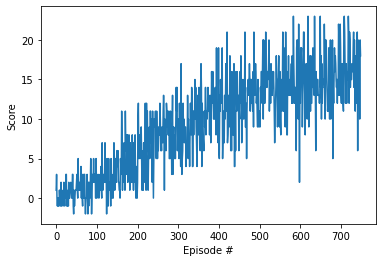

In [19]:
## Main function of Navigation to start the training process and report the scores
def dqn_nav(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    t_step = 0
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        # reset the environment and score
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]  
        score = 0
        
        for t in range(max_t):
            t_step += 1                                    # just a counter - used for UPDATE learning
            action = agent(state, eps)                     # select a epsilon greedy action
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward 
            done = env_info.local_done[0]
            
            score += reward  # add reward to the current score   
            train_agent(state, action, reward, next_state, done, t_step) # train Q Network
            state = next_state
            
            if done:
                break 
                
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=16.0: #Using score of 16, instead of 13, for exit criteria. Just to train little more
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(qnetwork_local.state_dict(), 'checkpoint_nav_dqn.pth')
            break
    return scores

scores = dqn_nav()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 7. Now test our trained Agent in the Environment

In the next code cell, once this cell is executed, we can watch the agent's performance. Check if get the score above 13 most of the time.

In [ ]:
qnetwork_local.load_state_dict(torch.load('checkpoint_nav_dqn.pth')) # load the previous trained loads

In [22]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = agent(state, 0.1)                     #  eps 0.1 here - not training anymore - still explore sometime
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 16.0


When finished, you can close the environment.

In [15]:
env.close()